# Import the necessary packages
## Install the gradcam packages using: 'pip install pytorch-gradcam'
The code repository is available at https://github.com/vickyliin/gradcam_plus_plus-pytorch

In [1]:
!pip install pytorch-gradcam

                                              0.0/6.0 MB ? eta -:--:--
                                              0.0/6.0 MB 660.6 kB/s eta 0:00:10
                                              0.1/6.0 MB 1.4 MB/s eta 0:00:05
     --                                       0.4/6.0 MB 2.8 MB/s eta 0:00:03
     ----                                     0.7/6.0 MB 4.2 MB/s eta 0:00:02
     -------                                  1.1/6.0 MB 4.9 MB/s eta 0:00:02
     ----------                               1.6/6.0 MB 6.0 MB/s eta 0:00:01
     -------------                            2.0/6.0 MB 6.5 MB/s eta 0:00:01
     ----------------                         2.5/6.0 MB 7.0 MB/s eta 0:00:01
     -------------------                      3.0/6.0 MB 7.4 MB/s eta 0:00:01
     --------------------                     3.1/6.0 MB 7.4 MB/s eta 0:00:01
     ------------------------                 3.6/6.0 MB 7.3 MB/s eta 0:00:01
     ---------------------------              4.1/6.0 MB 7.6 MB/s eta

In [2]:
import os
import cv2
import PIL
import numpy as np

import torch
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
from torchvision.utils import make_grid, save_image

import matplotlib.pyplot as plt

from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Download the imagenet_class_index.json file from the following link https://gist.github.com/AyushSomani001/17346595333e73fe78208756f11fcebb
## Load it

In [20]:
import json
imagenet_class_index = json.load(open('ImageNet_class_index.json'))

# Load the some example images of your choice

In [21]:
# Load the dog, cat, rooster and lizard images
dog = cv2.imread('/Users/emy016/Dropbox/Postdoc2/Kurs/NORA summer school 2023/docker/IDL/Assignments/dog.png')
cat = cv2.imread('/Users/emy016/Dropbox/Postdoc2/Kurs/NORA summer school 2023/docker/IDL/Assignments/cat.png')
rooster = cv2.imread('/Users/emy016/Dropbox/Postdoc2/Kurs/NORA summer school 2023/docker/IDL/Assignments/rooster.png')
lizard = cv2.imread('/Users/emy016/Dropbox/Postdoc2/Kurs/NORA summer school 2023/docker/IDL/Assignments/lizard.png')

## Resize them to 224x224

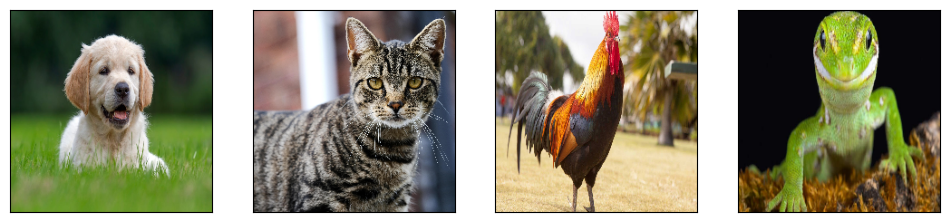

In [22]:
# Resize all the images to 224x224
dog = cv2.resize(dog, (224, 224))
cat = cv2.resize(cat, (224, 224))
rooster = cv2.resize(rooster, (224, 224))
lizard = cv2.resize(lizard, (224, 224))

fig = plt.figure(figsize=(12, 12))
for i, img in enumerate([dog, cat, rooster, lizard]):
    ax = fig.add_subplot(1, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(img[:, :, ::-1])

## Download a few test models of your choice

In [23]:
#alexnet = models.alexnet(pretrained=True)
#vgg = models.vgg16(pretrained=True)
#resnet = models.resnet101(pretrained=True)
#densenet = models.densenet161(pretrained=True)
#squeezenet = models.squeezenet1_1(pretrained=True)

yolov8 = 

/Users/emy016/opt/anaconda3/envs/tf/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/emy016/opt/anaconda3/envs/tf/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/emy016/opt/anaconda3/envs/tf/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also 

In [24]:
configs = [
    dict(model_type='alexnet', arch=alexnet, layer_name='features_11'),
    dict(model_type='vgg', arch=vgg, layer_name='features_29'),
    dict(model_type='resnet', arch=resnet, layer_name='layer4'),
    dict(model_type='densenet', arch=densenet, layer_name='features_norm5'),
    dict(model_type='squeezenet', arch=squeezenet, layer_name='features_12_expand3x3_activation')
]

## Get the results for gradCAM and gradCAM++

In [25]:
for config in configs:
    config['arch'].to(device).eval()

cams = [
    [cls.from_config(**config) for cls in (GradCAM, GradCAMpp)]
    for config in configs
]

## Test on any sample image of your choice

In [26]:
dog_tensor = transforms.Compose([
                                transforms.ToTensor()])(dog).to(device)
dog_normed_torch = transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])(dog_tensor)[None]

/Users/emy016/opt/anaconda3/envs/tf/lib/python3.10/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/Users/emy016/opt/anaconda3/envs/tf/lib/python3.10/site-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


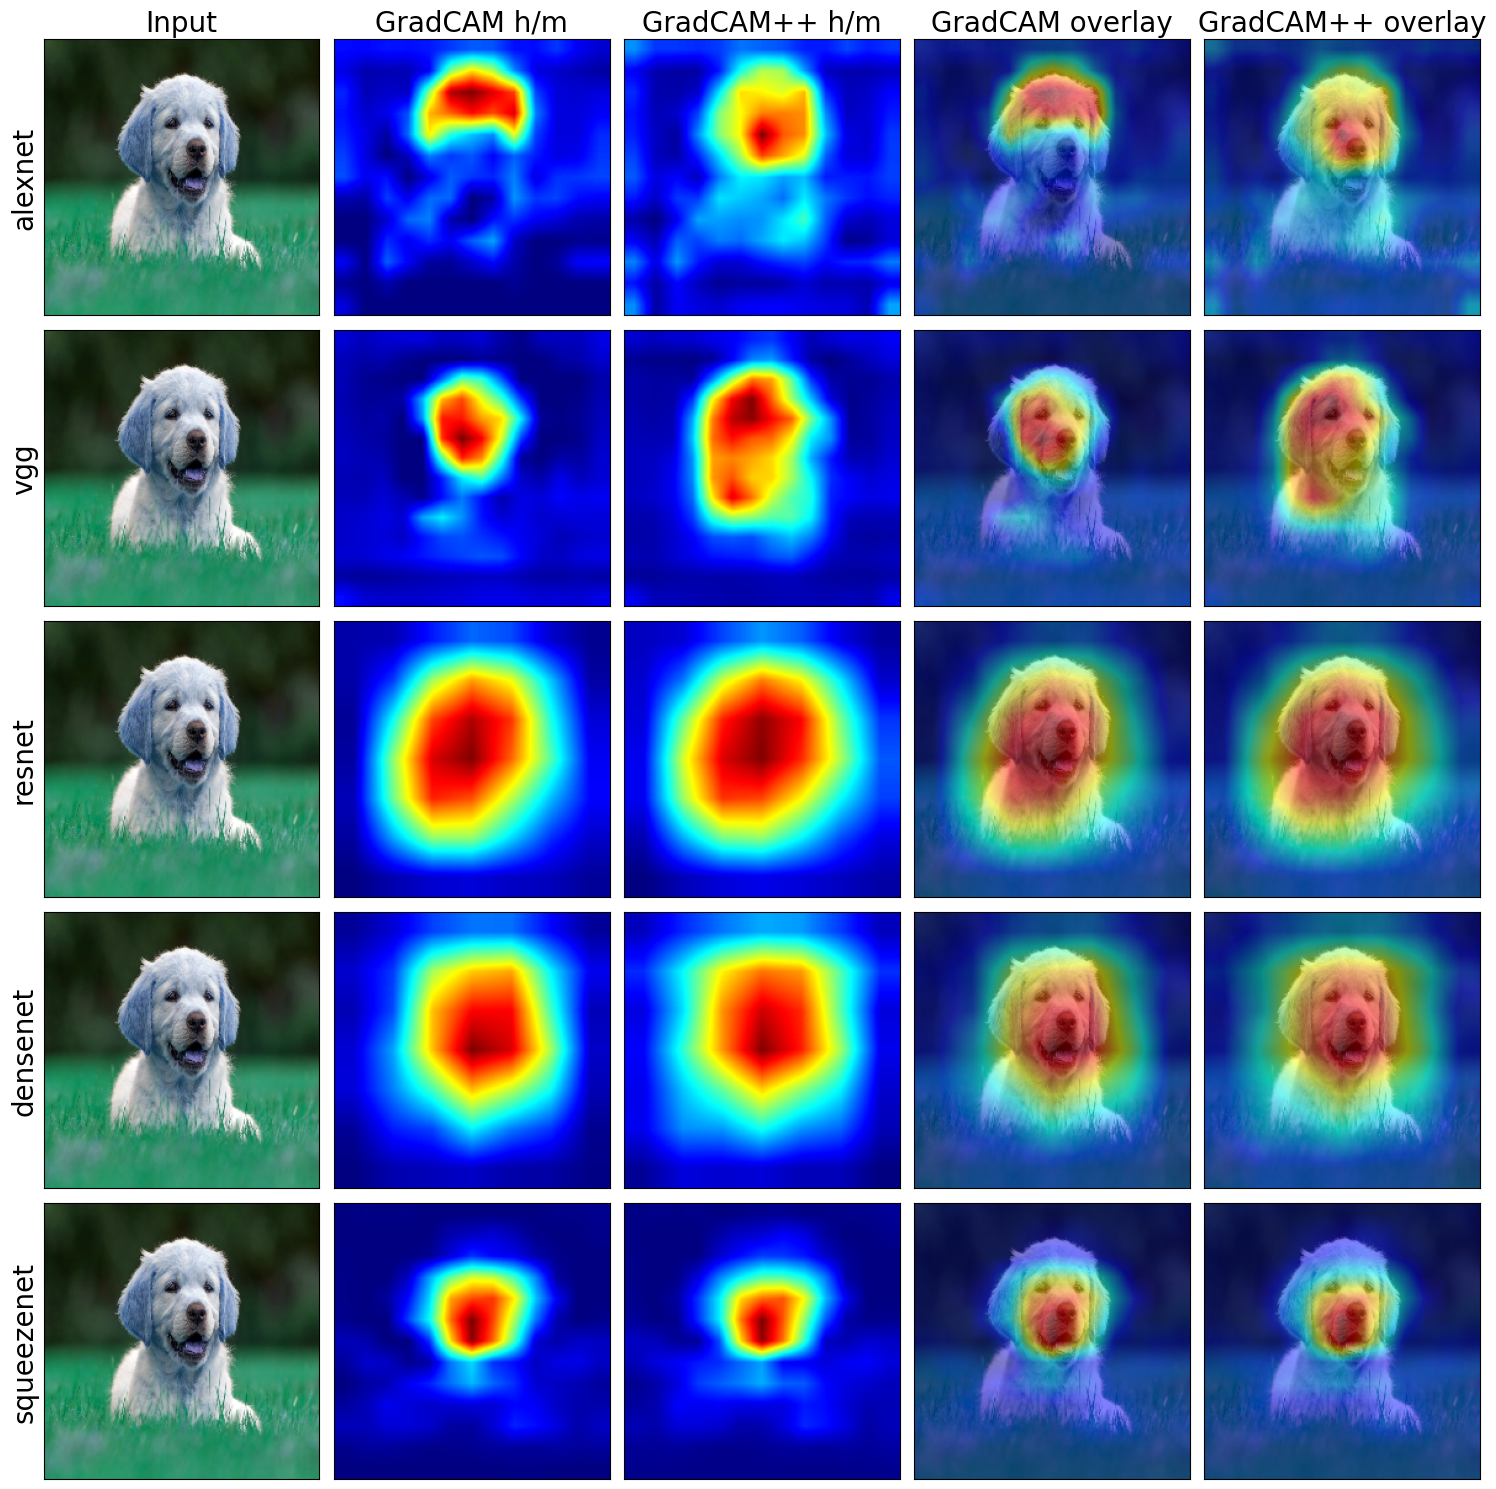

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.utils import make_grid

# Assuming you have the `images` tensor defined
images = np.zeros((5, 5, 3, 224, 224))

# Create a 5x5 grid of subplots
fig, axes = plt.subplots(5, 5, figsize=(15, 15))

i = 0

# Iterate over each subplot and display the corresponding image
for gradcam, gradcam_pp in cams:
    mask, _ = gradcam(dog_normed_torch)
    heatmap, result = visualize_cam(mask, dog_tensor)

    mask_pp, _ = gradcam_pp(dog_normed_torch)
    heatmap_pp, result_pp = visualize_cam(mask_pp, dog_tensor)

    images[i, 0, :, :, :] = dog_tensor.cpu().numpy().reshape(3, 224, 224)
    images[i, 1, :, :, :] = heatmap.cpu().numpy().reshape(3, 224, 224)
    images[i, 2, :, :, :] = heatmap_pp.cpu().numpy().reshape(3, 224, 224)
    images[i, 3, :, :, :] = result.cpu().numpy().reshape(3, 224, 224)
    images[i, 4, :, :, :] = result_pp.cpu().numpy().reshape(3, 224, 224)

    for j in range(5):
        ax = axes[i, j]
        ax_x = axes[i, 0]
        image = images[i, j]  # Select individual image from the tensor

        # Reshape or transpose the image tensor if needed
        image = np.transpose(image, (1, 2, 0))  # Assuming the shape is (3, 224, 224)

        ax.imshow(image)
        ax.set_xticks([])
        ax.set_yticks([])

    i += 1

# Set the x labels for each column as the name of the technique used
for j in range(5):
    axes[0, j].set_title(['Input', 'GradCAM h/m', 'GradCAM++ h/m', 'GradCAM overlay', 'GradCAM++ overlay'][j], fontsize=20)

# Set the y labels for each row as the name of the model
for i in range(5):
    axes[i, 0].set_ylabel(configs[i]['model_type'], fontsize=20)

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


## Print the predicted class with maximum probability. Here we showcase the resnet model. You can use any model of your choice

In [28]:
# Print the predicted class for the dog image wih the highest probability with reference to the imagenet class index
# Predict the class for the dog image
class_idx = torch.argmax(resnet(dog_normed_torch))
predicted_class = imagenet_class_index[str(class_idx.item())]
print(f'Predicted Class = {predicted_class}')

Predicted Class = Great Pyrenees


# **Task**: Repeat the same steps for another image of your choice. You can use any model of your choice, say VGG model.

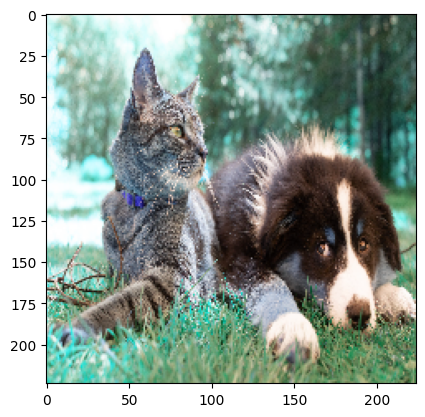

In [32]:
# Assuming you define the `images` tensor here
cat_and_dog = cv2.imread("/Users/emy016/Dropbox/Postdoc2/Kurs/NORA summer school 2023/docker/IDL/Assignments/cat_and_dog.jpg")
# Resize to 224x224
cat_and_dog = cv2.resize(cat_and_dog, (224, 224))


cat_and_dog_tensor = transforms.Compose([
                                transforms.ToTensor()])(cat_and_dog).to(device)
cat_and_dog_normed_torch = transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])(cat_and_dog_tensor)[None]


#cv2.imshow(cat_and_dog)

cv2.imshow("title",cat_and_dog)

plt.imshow(cat_and_dog)
plt.show()

#ax = fig.add_subplot(1, 4, i + 1, xticks=[], yticks=[])
#ax.imshow(img[:, :, ::-1])

#for i, img in enumerate([dog, cat, rooster, lizard]):
#    ax = fig.add_subplot(1, 4, i + 1, xticks=[], yticks=[])
#    ax.imshow(img[:, :, ::-1])

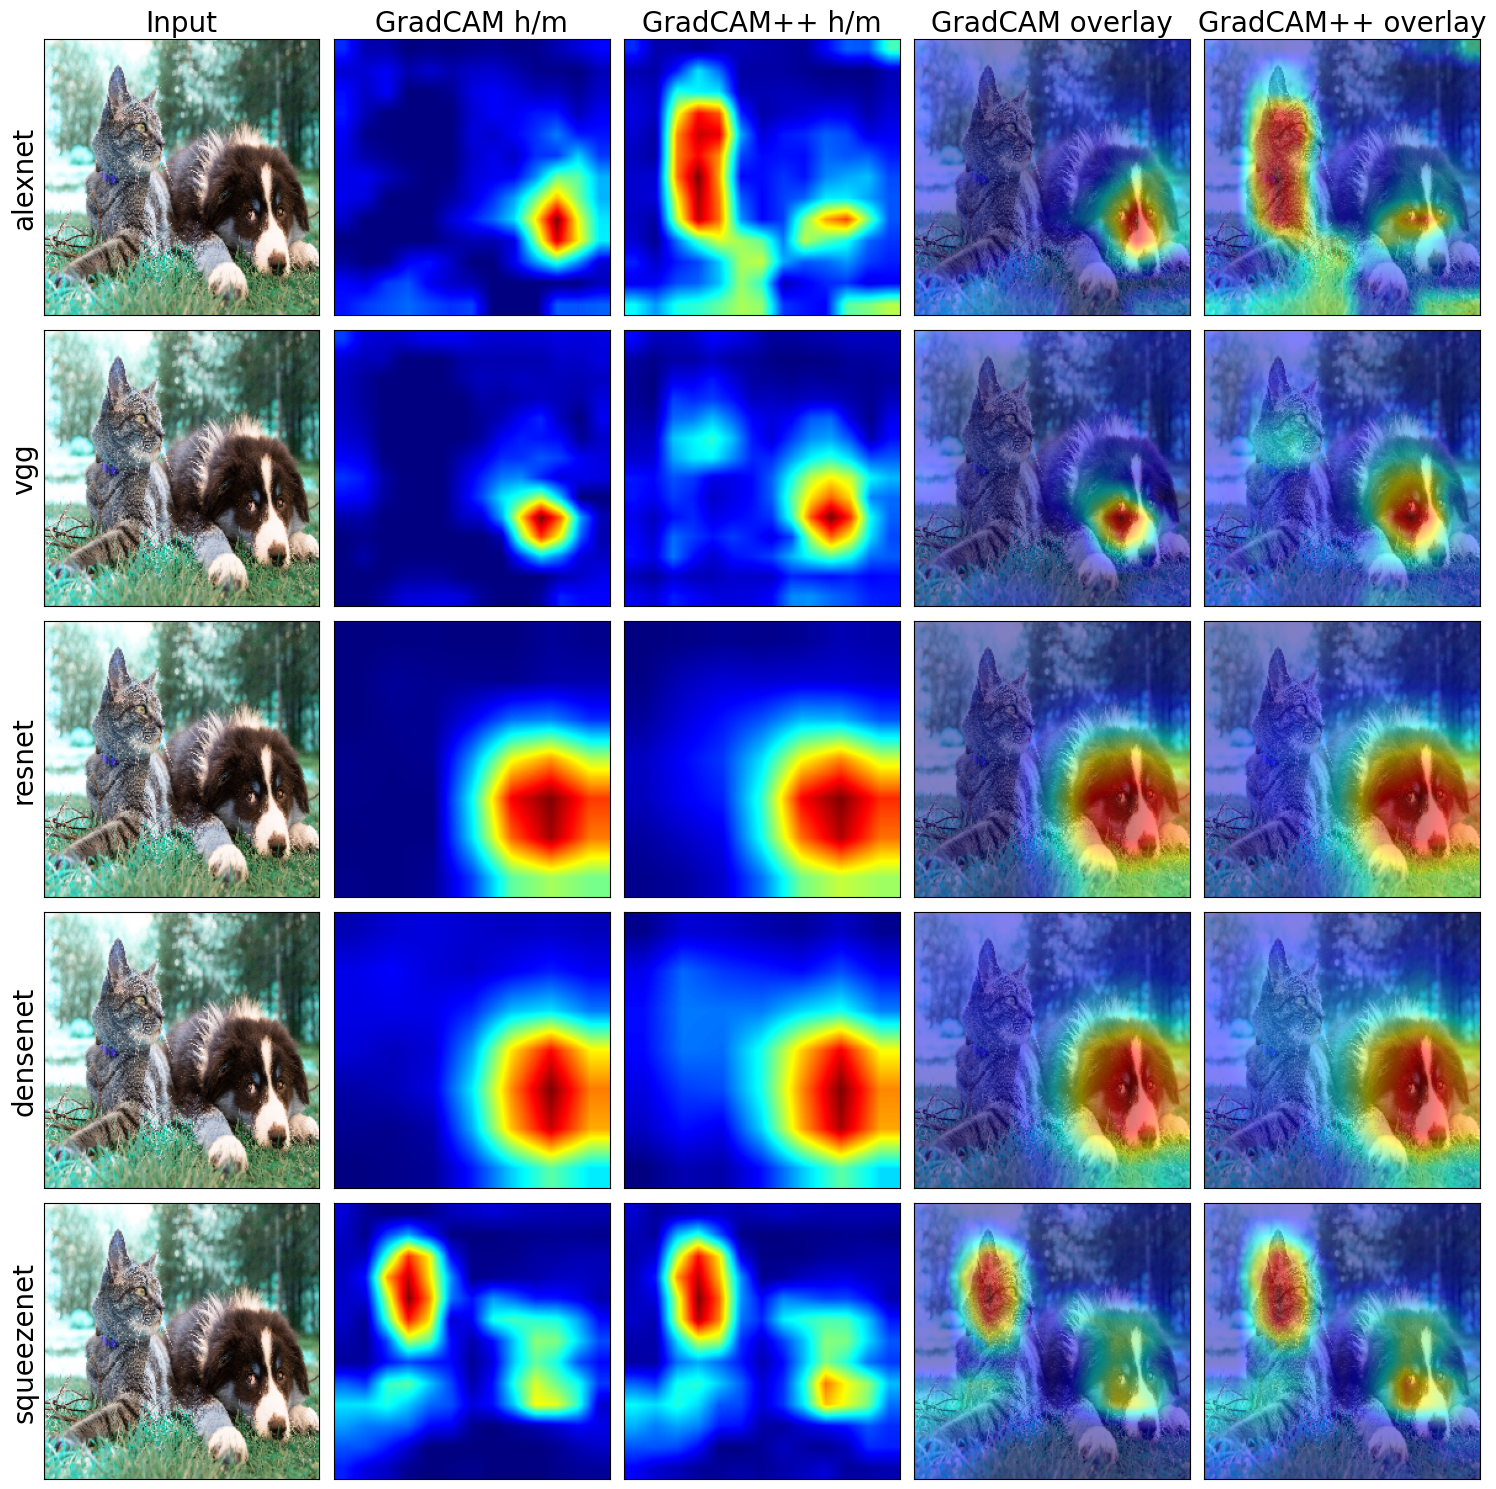

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.utils import make_grid

# Assuming you have the `images` tensor defined
images = np.zeros((5, 5, 3, 224, 224))

# Create a 5x5 grid of subplots
fig, axes = plt.subplots(5, 5, figsize=(15, 15))

i = 0

# Iterate over each subplot and display the corresponding image
for gradcam, gradcam_pp in cams:
    mask, _ = gradcam(cat_and_dog_normed_torch)
    heatmap, result = visualize_cam(mask, cat_and_dog_tensor)

    mask_pp, _ = gradcam_pp(cat_and_dog_normed_torch)
    heatmap_pp, result_pp = visualize_cam(mask_pp, cat_and_dog_tensor)

    images[i, 0, :, :, :] = cat_and_dog_tensor.cpu().numpy().reshape(3, 224, 224)
    images[i, 1, :, :, :] = heatmap.cpu().numpy().reshape(3, 224, 224)
    images[i, 2, :, :, :] = heatmap_pp.cpu().numpy().reshape(3, 224, 224)
    images[i, 3, :, :, :] = result.cpu().numpy().reshape(3, 224, 224)
    images[i, 4, :, :, :] = result_pp.cpu().numpy().reshape(3, 224, 224)

    for j in range(5):
        ax = axes[i, j]
        ax_x = axes[i, 0]
        image = images[i, j]  # Select individual image from the tensor

        # Reshape or transpose the image tensor if needed
        image = np.transpose(image, (1, 2, 0))  # Assuming the shape is (3, 224, 224)

        ax.imshow(image)
        ax.set_xticks([])
        ax.set_yticks([])

    i += 1

# Set the x labels for each column as the name of the technique used
for j in range(5):
    axes[0, j].set_title(['Input', 'GradCAM h/m', 'GradCAM++ h/m', 'GradCAM overlay', 'GradCAM++ overlay'][j], fontsize=20)

# Set the y labels for each row as the name of the model
for i in range(5):
    axes[i, 0].set_ylabel(configs[i]['model_type'], fontsize=20)

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.utils import make_grid


# Assuming you have the `images` tensor defined

# Create a 5x5 grid of subplots


# Iterate over each subplot and display the corresponding image



# Set the x labels for each column as the name of the technique used


# Set the y labels for each row as the name of the model



# Adjust spacing between subplots


# Display the plot

In [36]:
# Print the predicted class for the selected image wih the highest probability with reference to the imagenet class index


# Predict the class for the selected image

# Print the predicted class for the dog image wih the highest probability with reference to the imagenet class index
# Predict the class for the dog image
class_idx = torch.argmax(resnet(cat_and_dog_normed_torch))
predicted_class = imagenet_class_index[str(class_idx.item())]
print(f'Predicted Class = {predicted_class}')

Predicted Class = Border collie


# Let us try to create an image using cropped versions of other images and see what the results are

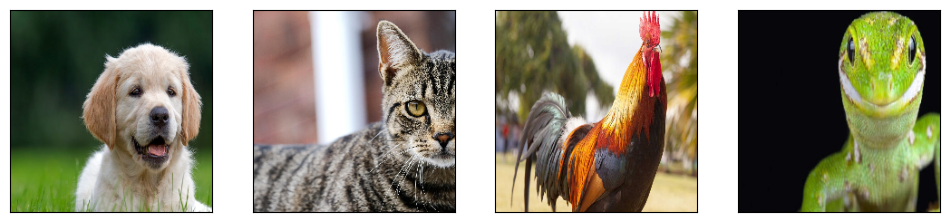

: 

In [56]:
# Create a 224x224 image with cropped parts of four single object image, say we use the above example of dog, cat, rooster, and lizard in each of its four corners.

#dog = cv2.resize(dog, (224, 224))
#cat = cv2.resize(cat, (224, 224))
#rooster = cv2.resize(rooster, (224, 224))
#lizard = cv2.resize(lizard, (224, 224))
dog = cv2.imread("/Users/emy016/Dropbox/Postdoc2/Kurs/NORA summer school 2023/docker/IDL/Assignments/dog.png")
cat = cv2.imread("/Users/emy016/Dropbox/Postdoc2/Kurs/NORA summer school 2023/docker/IDL/Assignments/cat.png")
rooster = cv2.imread("/Users/emy016/Dropbox/Postdoc2/Kurs/NORA summer school 2023/docker/IDL/Assignments/rooster.png")
lizard = cv2.imread("/Users/emy016/Dropbox/Postdoc2/Kurs/NORA summer school 2023/docker/IDL/Assignments/lizard.png")

dogshape = dog.shape
catshape = cat.shape
roostershape = rooster.shape
lizardshape = lizard.shape

croprate = 0.75
dogc = dog[0:round(croprate*dogshape[0]),0:round(croprate*dogshape[1])]
catc = cat[0:round(croprate*catshape[0]),0:round(croprate*catshape[1])]
roosterc = rooster[0:round(croprate*roostershape[0]),0:round(croprate*roostershape[1])]
lizardc = lizard[0:round(croprate*lizardshape[0]),0:round(croprate*lizardshape[1])]

# Resize to 224x224
dog = cv2.resize(dogc, (224, 224))
cat = cv2.resize(catc, (224, 224))
rooster = cv2.resize(roosterc, (224, 224))
lizard = cv2.resize(lizardc, (224, 224))

fig = plt.figure(figsize=(12, 12))
for i, img in enumerate([dog, cat, rooster, lizard]):
    ax = fig.add_subplot(1, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(img[:, :, ::-1])

#plt.imshow(dog)
#plt.show()
#plt.imshow(cat)
#plt.show()
#plt.imshow(roosterc)
#plt.show()
#plt.imshow(lizardc)
#plt.show()

In [ ]:
# Convert the image to a tensor and normalize it with mean and standard deviation




# ....